In [ ]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=1a71fc35cbad712d33e4703417414e9349e80e551de91ab6b33f6e0cf775f40b
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
# ARIMA
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import warnings
import itertools
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import math
import json
import csv
import ast

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:


def optimal_para_selection(series, i):
  # Define the p, d and q parameters to take any value between 0 and 2
  p = d = q = range(0, 2)

  # Generate all different combinations of seasonal p, q and q triplets
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

  # Generate all different combinations of p, q and q triplets
  pdq = list(itertools.product(p, d, q))
  warnings.filterwarnings("ignore") # specify to ignore warning messages
  
  aic = 1000000000
  param_optimal = 0
  param_seasonal_optimal = 0
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(series,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

              results = mod.fit()
              if results.aic < aic:
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                aic = results.aic
                param_optimal = param
                param_seasonal_optimal = param_seasonal
          except:
              continue
  return (param_optimal, param_seasonal_optimal, aic)



In [ ]:



def evaluate_model(series, param_optimal, param_seasonal_optimal):

  mod = sm.tsa.statespace.SARIMAX(series,
                                order=param_optimal,
                                seasonal_order=param_seasonal_optimal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

  results = mod.fit()
  
  
  return results


In [ ]:

def evaluate_plot(i, series,results, test_start_day, plot_start_day,fig):
  sub = fig.add_subplot(6,5,i+16)
  test_start_day = series[test_start_day-relativedelta(days=+6):test_start_day].index[0].date()
  test_start_day = datetime.strptime(str(test_start_day), '%Y-%m-%d').date()
  pred = results.get_prediction(start=pd.to_datetime(test_start_day), dynamic=False)
  # fig=plt.figure(figsize=(15, 15))
  ax = series[plot_start_day:].plot()#label='observed')
  pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
  pred_ci = pred.conf_int()
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.2)

  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
  #plt.show()
  # plt.savefig('Evaluate Plot: Rebalance Period ')
  return ax



In [ ]:


def train_model(series_train, param_optimal, param_seasonal_optimal):
  
  mod = sm.tsa.statespace.SARIMAX(series_train,
                                  order=param_optimal,
                                  seasonal_order=param_seasonal_optimal,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

  results = mod.fit()

  return results



In [ ]:
def prediction(train_result,i):
  # Get forecast 500 steps ahead in future
  pred_uc = train_result.get_forecast(steps=len(test))

  # Get confidence intervals of forecasts
  pred_ci = pred_uc.conf_int()
  test['pred'+str(i)] = pred_uc.predicted_mean.values
  return test



In [ ]:
def investment_plot(i,series_train, numOfETF,actual,fig):
  # fig=plt.figure(figsize=(15, 15))
  
  if actual:
    sub = fig.add_subplot(6, 5, i+1)
    ax = test.iloc[:,i].plot(label='actual')
    #print(test.iloc[:,i])
    test.iloc[:,i+numOfETF].plot(ax=ax,label='predicted')
  else: 
    sub = fig.add_subplot(3, 5, i+1)
    ax = test.iloc[:,i+numOfETF].plot(label='predicted')
  #print(test.iloc[:,i+14])
  series_train.plot()
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()

  # plt.savefig('Investment Plot: Rebalance Period ' + str(i))
  # return ax


In [ ]:
# download data from yahoo finance
tickers = 'SPY XLK IWO VXUS XIC.TO BND SHY VCSH IGOV XBB.TO XSH.TO VHT GLD VNQ'
# data = yf.download(tickers=tickers, start="2012-01-01", end=invest_end_day,interval='1wk')
final_day = datetime.strptime('2020-05-31', '%Y-%m-%d').date()
df = yf.download(tickers=tickers, start="2012-01-01", end=final_day,interval='1wk')['Adj Close'].dropna()


numOfETF = len(df.columns)
 # reduce dataframe to rows, where all asset prices are present
plot_start_day = '2012'
# initialize 
invest_end_day = datetime.strptime("2015-04-01", '%Y-%m-%d').date()

# end_date = datetime.strptime(final_day, '%Y-%m-%d').date()
start_date = invest_end_day
num_months = (final_day.year - start_date.year) * 12 + (final_day.month - start_date.month)
num_of_forcast = math.ceil(num_months/6)

forcast_monthly_return_table = pd.DataFrame()
# print(forcast_monthly_return_table)
#print(df)

[*********************100%***********************]  14 of 14 completed


In [ ]:
# download risk free data from yahoo finance
RF_tickers = '^IRX'
# calcualte rf
Rf_price = yf.download(tickers=RF_tickers, start="2012-01-01", end=final_day,interval='1wk')['Adj Close'].dropna()

Rf_return = Rf_price.resample('M').ffill().pct_change().dropna()


#print(Rf_return)
# read forcast expected return of ETFs
Rp = pd.read_csv("expected_return_rebalance.csv",index_col='ETFs')
#print(Rp)
rf_table = pd.DataFrame()
# etf return
ETF_return = df.resample('M').ffill().pct_change().dropna()
#print(ETF_return)
# column is date, row is ETF name
excess_return = ETF_return.T-Rf_return.T
#print(excess_return)
Q_excess_return_cov = {}
print(excess_return)

[*********************100%***********************]  1 of 1 completed
Date    2012-02-29  2012-03-31  2012-04-30  ...  2020-03-31  2020-04-30  2020-05-31
BND       0.144572   -0.086510   -0.065647  ...    0.945604   -0.585594   -0.367236
GLD       0.135102   -0.108703   -0.093269  ...    0.981623   -0.556740   -0.356755
IGOV      0.128262   -0.065103   -0.068336  ...    0.915743   -0.580903   -0.368727
IWO       0.117144   -0.053970   -0.122740  ...    0.693426   -0.397625   -0.240736
SHY       0.141685   -0.083748   -0.074906  ...    0.964702   -0.602455   -0.374820
SPY       0.163446   -0.053349   -0.103981  ...    0.795516   -0.464039   -0.300210
VCSH      0.149537   -0.084560   -0.071820  ...    0.908940   -0.569538   -0.358257
VHT       0.145326   -0.042994   -0.095867  ...    0.880158   -0.464733   -0.311346
VNQ       0.110482   -0.044489   -0.043229  ...    0.697534   -0.463823   -0.323448
VXUS      0.157631   -0.091373   -0.122268  ...    0.759696   -0.513663   -0.300311
XBB.TO 

In [ ]:
# no need to run

run_loop=False
if run_loop:
  #for j in range(2):
  for j in range(num_of_forcast):
    forcast_monthly_return = [0]*len(df.columns)
    # loop inside relablance

    invest_start_day = invest_end_day
    invest_end_day = invest_start_day + relativedelta(months=+6)
    #invet_end_day.strftime('%Y-%m-%d')
    #print(df[[invest_end_day,'BND']])
    # for last forcast period less than 6 months, use final day as last day
    if invest_end_day > final_day:
      invest_end_day = final_day

    end_day = invest_start_day - relativedelta(days=1)
    test_start_day = end_day - relativedelta(years=2)

    test = df[invest_start_day:invest_end_day]

  # transpose data to filter by date
    excess_return_T = excess_return.T
    historical_excess_return = excess_return_T[:end_day]
    # transpose back data to get the coverance
    historical_excess_return_T = historical_excess_return.T
    Q_excess_return_cov[invest_start_day] = np.cov(historical_excess_return_T)*4 # convert from weekly to monthly
    # # rf: 
    # # print(invest_start_day)
    # Rf_list = [float(Rf_return[invest_start_day+relativedelta(months=-1):invest_start_day].values)]*len(df.columns)
    # # # print(Rf_return[invest_start_day+relativedelta(months=-1):invest_start_day].index[0])
    # # # create rf table (Rf for 6 months ago)
    # rf_table[invest_end_day] = Rf_list
    #for i in range(1):
    fig = plt.figure(figsize=(15,15))
    for i in range(len(df.columns)):
    # for model selection 
      series = df[:end_day]
      series = series.iloc[:,i].dropna()
      param_optimal, param_seasonal_optimal, aic = optimal_para_selection(series,i)
      # results = evaluate_model(series,param_optimal, param_seasonal_optimal)
      # evaluate_plot(i, series, results,test_start_day,plot_start_day) 

      # for rebalance
      series_train = series # [test_start_day:end_day]
      train_result = train_model(series_train,param_optimal, param_seasonal_optimal)
      # test data frame adding the predicted value
      test = prediction(train_result,i)
      # print(test.head())
      #  performance of first rebalancing 

      investment_plot(i,series_train,numOfETF, False, fig) # NOT plot actual price
      #plt.subplot(ax)
      # calculate monthly return
      forcast_monthly_return[i] = test['pred'+str(i)].resample('M').ffill().pct_change().dropna().mean()
    fig.tight_layout()
    plt.savefig("Investment Plot: Rebalance Period "+str(j))

    forcast_monthly_return_table[invest_start_day] = forcast_monthly_return
  forcast_monthly_return_table.insert(0,column='ETFs',value=df.columns)  
  forcast_monthly_return_table.to_csv("expected_return_rebalance.csv",index=False)

  # save Q output
  # no headers, first column is date, second column is covariance matrix Q
  with open('Q_output.csv',"w", newline="") as f:
    writer = csv.writer(f)
    for key, val in Q_excess_return_cov.items():
      writer.writerow([key, val])

In [ ]:
invest_end_day = datetime.strptime("2015-04-01", '%Y-%m-%d').date()
#for j in range(1):
for j in range(num_of_forcast):
 
  # loop inside relablance

  invest_start_day = invest_end_day
  invest_end_day = invest_start_day + relativedelta(months=+6)
  #invet_end_day.strftime('%Y-%m-%d')
  #print(df[[invest_end_day,'BND']])
  # for last forcast period less than 6 months, use final day as last day
  if invest_end_day > final_day:
    invest_end_day = final_day

  end_day = invest_start_day - relativedelta(days=1)
  test_start_day = end_day - relativedelta(years=2)

  # # print(invest_start_day)
  Rf_list = [float(Rf_return[invest_start_day+relativedelta(months=-1):invest_start_day].values)]*len(df.columns)
  # # print(Rf_return[invest_start_day+relativedelta(months=-1):invest_start_day].index[0])
  # # create rf table (Rf for 6 months ago)
  rf_table[invest_start_day] = Rf_list

In [ ]:
# read csv file
forcast_monthly_return_table = pd.read_csv("expected_return_rebalance.csv",index_col='ETFs')

# read Q
reader = csv.reader(open('Q_output.csv', 'r', newline=''))
Q_excess_return_cov_read = {}
for row in reader:
    k, v = row
    v = v.replace("\n ","").replace("][","] [").replace(" ]","]")
    v = ' '.join(v.split())
    Q_excess_return_cov_read[k] = np.asarray(json.loads(v.replace(" ",",")),dtype=np.float32)

# calculate the input parameter for black litterman
sigma_dict ={}
Rp_rf = {}
risk_aversion_lambda = {}
xmkt_weight ={}
PI = {}
u = 0;
# print(Q_excess_return_cov)
for date_key in Q_excess_return_cov_read:
    #print(type(Q_excess_return_cov_read[date_key]))
    xmkt_weight[date_key] = forcast_monthly_return_table["weight"].to_numpy().T 
    # monthly covariance
    sigma_dict[date_key] = np.dot(np.dot(xmkt_weight[date_key],Q_excess_return_cov_read[date_key]),xmkt_weight[date_key].T)
    Rp_rf[date_key] = np.dot(forcast_monthly_return_table.iloc[:,u],xmkt_weight[date_key]) - rf_table.iloc[1,u]
    #Rp_rf[date_key]  = forcast_monthly_return[u]  - rf_table_bt[u] 
    # lambda
    risk_aversion_lambda[date_key]  = Rp_rf[date_key] /sigma_dict[date_key] 
    ##print(risk_aversion_lambda[date_key])
    # implied equilibruim return vector
    PI[date_key]  = risk_aversion_lambda[date_key] *np.dot(Q_excess_return_cov_read[date_key],xmkt_weight[date_key])
    #print(PI[date_key])
    u = u + 1;
PI

{'2015-04-01': array([-0.24495905, -0.24502231, -0.2450944 , -0.24657446, -0.24509125,
        -0.24487266, -0.24507031, -0.24514748, -0.24491086, -0.24526897,
        -0.24485194, -0.24472221, -0.24403045, -0.2450825 ]),
 '2015-10-01': array([0.68109829, 0.68315774, 0.68137051, 0.68140311, 0.68141302,
        0.68109116, 0.68130875, 0.68082646, 0.68036479, 0.6820454 ,
        0.68082609, 0.6817262 , 0.6806688 , 0.68127109]),
 '2016-04-01': array([0.18178275, 0.18224035, 0.18189106, 0.18177721, 0.18184557,
        0.18162591, 0.18182171, 0.18166339, 0.18154413, 0.18190664,
        0.18172213, 0.18188986, 0.18145937, 0.18181454]),
 '2016-10-01': array([0.14549885, 0.14589488, 0.14558808, 0.14549848, 0.14554574,
        0.14536581, 0.1455275 , 0.14539499, 0.14530114, 0.14560653,
        0.14544897, 0.14559706, 0.14523275, 0.14551949]),
 '2017-04-01': array([-0.07728837, -0.07750124, -0.07733271, -0.07729599, -0.07731496,
        -0.07722337, -0.07730502, -0.07723472, -0.07718407, -0.0773

In [ ]:
### backtesting

In [ ]:

# data = yf.download(tickers=tickers, start="2012-01-01", end=invest_end_day,interval='1wk')
final_day = datetime.strptime('2015-03-31', '%Y-%m-%d').date()
df = yf.download(tickers=tickers, start="2012-01-01", end=final_day,interval='1wk')['Adj Close'].dropna()
numOfETF = len(df.columns)
 # reduce dataframe to rows, where all asset prices are present
plot_start_day = '2012'
# initialize 
invest_end_day = datetime.strptime("2014-04-01", '%Y-%m-%d').date()

# end_date = datetime.strptime(final_day, '%Y-%m-%d').date()
start_date = invest_end_day
num_months = (final_day.year - start_date.year) * 12 + (final_day.month - start_date.month)
num_of_forcast = math.ceil(num_months/6)

forcast_monthly_return_table_bt = pd.DataFrame()

print(num_of_forcast)


[*********************100%***********************]  14 of 14 completed
2


In [ ]:

# calcualte rf
Rf_price = yf.download(tickers=RF_tickers, start="2012-01-01", end=final_day,interval='1wk')['Adj Close'].dropna()

Rf_return = Rf_price.resample('M').ffill().pct_change().dropna()

#print(Rp)
rf_table_bt = pd.DataFrame()
# etf return
ETF_return = df.resample('M').ffill().pct_change().dropna()
#print(ETF_return)
# column is date, row is ETF name
excess_return = ETF_return.T-Rf_return.T
#print(excess_return)
Q_excess_return_cov_bt = {}

[*********************100%***********************]  1 of 1 completed


In [ ]:
#for j in range(2):
for j in range(num_of_forcast):
  forcast_monthly_return = [0]*len(df.columns)
  # loop inside relablance

  invest_start_day = invest_end_day
  invest_end_day = invest_start_day + relativedelta(months=+6)
  # for last forcast period less than 6 months, use final day as last day

  if invest_end_day > final_day:
    invest_end_day = final_day
  
  end_day = invest_start_day - relativedelta(days=1)
  test_start_day = end_day - relativedelta(years=1)
  test = df[invest_start_day:invest_end_day]
  
  # transpose data to filter by date
  excess_return_T = excess_return.T
  historical_excess_return = excess_return_T[:end_day]
  # transpose back data to get the coverance
  historical_excess_return_T = historical_excess_return.T
  Q_excess_return_cov_bt[invest_start_day] = np.cov(historical_excess_return_T)*4
  # # rf: 
  # # print(invest_start_day)
  Rf_list = [float(Rf_return[invest_start_day+relativedelta(months=-1):invest_start_day].values)]*len(df.columns)
  # # print(Rf_return[invest_start_day+relativedelta(months=-1):invest_start_day].index[0])
  # # create rf table (Rf for 6 months ago)
  rf_table_bt[invest_start_day] = Rf_list
 
  fig = plt.figure(figsize=(30,30))
  #fig_investment = plt.figure()
  # for i in range(1):
  for i in range(len(df.columns)):
  # for model selection 
    series = df[:end_day]
    series = series.iloc[:,i].dropna()
    param_optimal, param_seasonal_optimal, aic = optimal_para_selection(series,i)
    results = evaluate_model(series,param_optimal, param_seasonal_optimal)
    print(results.summary().tables[1])
    evaluate_plot(i, series, results,test_start_day,plot_start_day, fig) 

    # for rebalance
    # use all the historical data to train the model
    series_train = series #[test_start_day:end_day]

    train_result = train_model(series_train,param_optimal, param_seasonal_optimal)

    # test data frame adding the predicted value
    test = prediction(train_result,i)
    #  performance of first rebalancing 
    investment_plot(i,series_train,numOfETF,True, fig)

    # calculate monthly return
    forcast_monthly_return[i] = test['pred'+str(i)].resample('M').ffill().pct_change().dropna().mean()
  forcast_monthly_return_table_bt[invest_start_day] = forcast_monthly_return
  fig.tight_layout()
  plt.savefig("Evaluate and Investment Plot: Rebalance Period "+str(j))
  #fig_investment.savefig("Investment Plot: Rebalance Period "+str(j))

forcast_monthly_return_table_bt.insert(0,column='ETFs',value=df.columns)  
forcast_monthly_return_table_bt.to_csv("expected_return_validate.csv",index=False)

# save Q output
# no headers, first column is date, second column is covariance matrix Q
with open('Q_output_bt.csv',"w", newline="") as f:
  writer = csv.writer(f)
  for key, val in Q_excess_return_cov_bt.items():
    writer.writerow([key, val])



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1757      0.105     -1.676      0.094      -0.381       0.030
ma.S.L12      -0.0700      0.123     -0.567      0.570      -0.312       0.172
sigma2         0.1012      0.010      9.977      0.000       0.081       0.121
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0396      0.091      0.437      0.662      -0.138       0.217
ma.S.L12      -1.0000    963.905     -0.001      0.999   -1890.218    1888.218
sigma2        10.8620   1.05e+04      0.001      0.999   -2.05e+04    2.05e+04
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0506      0.103     -0.491      0.6

In [ ]:
forcast_monthly_return_table_bt = pd.read_csv("expected_return_validate.csv",index_col='ETFs')
forcast_monthly_return_table = pd.read_csv("expected_return_rebalance.csv",index_col='ETFs')#
# read Q
reader = csv.reader(open('Q_output_bt.csv', 'r', newline=''))
Q_excess_return_cov_bt = {}
for row in reader:
    k, v = row
    v = v.replace("\n ","").replace("][","] [").replace(" ]","]")
    v = ' '.join(v.split())
    #print(v)
    Q_excess_return_cov_bt[k] = np.asarray(json.loads(v.replace(" ",",")),dtype=np.float32)
#print(Q_excess_return_cov_bt)
sigma_dict_bt ={}
Rp_rf_bt = {}
risk_aversion_lambda_bt = {}
xmkt_weight_bt ={}
PI_bt = {}
u = 0;
for date_key in Q_excess_return_cov_bt:
    #print(forcast_monthly_return_table["weight"].to_numpy().T)
    xmkt_weight_bt[date_key] = forcast_monthly_return_table["weight"].to_numpy().T 
    
    sigma_dict_bt[date_key] = np.dot(np.dot(xmkt_weight_bt[date_key],Q_excess_return_cov_bt[date_key]),xmkt_weight_bt[date_key].T)
    #print(u)
    #print(rf_table_bt)
    Rp_rf_bt[date_key] = np.dot(forcast_monthly_return_table_bt.iloc[:,u],xmkt_weight_bt[date_key]) - rf_table_bt.iloc[1,u]
    #print(np.dot(forcast_monthly_return_table_bt.iloc[:,u],xmkt_weight.T))
    #Rp_rf[date_key]  = forcast_monthly_return[u]  - rf_table_bt[u] 
    # lambda
    risk_aversion_lambda_bt[date_key]  = Rp_rf_bt[date_key] /sigma_dict_bt[date_key] 
    #print(risk_aversion_lambda)
    # implied equilibruim return vector
    PI_bt[date_key]  = risk_aversion_lambda_bt[date_key] *np.dot(Q_excess_return_cov_bt[date_key],xmkt_weight_bt[date_key])
    #print(PI[date_key])
    u = u + 1;
#PI_bt

In [ ]:
# # view matrix
# identity_matrix = pd.DataFrame(np.identity(len(df.columns)),index=forcast_monthly_return_table.index,columns=forcast_monthly_return_table.index)

# p_table = pd.DataFrame()
# q_table = pd.DataFrame()

# number_of_view = 2 # number of view
# # loop each rebalance period
# for w in range(1):
#   p_matrix=forcast_monthly_return_table.iloc[:,w]
#   q=[0] * number_of_view

#   p_table[0] = np.array(identity_matrix.loc['BND'])-np.array(identity_matrix['GLD'])
#   p_table[1] = np.array(identity_matrix.loc['VNQ']) - np.array(identity_matrix['IGOV'])
#   q = np.dot(np.array(p_table).T,np.array(p_matrix))
#   # q[0] = np.dot(np.array(p_matrix),np.array(p_table[1]))
#   # q[1] = np.dot(np.array(p_matrix),np.array(p_table[2]))
  
#   q_table[0]=q
#   print(p_table)
#   print(q_table)

#   P=p_table.T.to_numpy()
#   print(P)

#   Q=q_table.to_numpy()
#   print(Q)



In [ ]:
import numpy as np
import pandas as pd
from numpy import linalg,dot,ones

import pandas as pd
import pandas_datareader.data as web
import scipy.optimize 
import datetime
import math
from dateutil.relativedelta import relativedelta
#from cvxopt import matrix, solvers,spmatrix
from pandas.tseries.offsets import BDay
from scipy.stats import skew, kurtosis

In [ ]:
#start and end of the range of the available data
start_date=datetime.datetime(2012,1,1)
end_date=datetime.datetime(2020,6,30)
#start and end of the investment period
investment_start_date=datetime.datetime(2015,4,1)
investment_end_date=datetime.datetime(2020,5,31)
#how many rebalance need
num_months = (investment_end_date.year - investment_start_date.year) * 12 + (investment_end_date.month - investment_start_date.month)
num_of_rebalance = math.ceil(num_months/6)
#initialize
period_end = datetime.datetime(2015,4,1)

#calculating a list of lamda for each rebalance period
lamda_list = [risk_aversion_lambda [k] for k in sorted(risk_aversion_lambda.keys())]
#calculating weight for each rebalance period
weight_list = [xmkt_weight [m] for m in sorted(xmkt_weight.keys())]

ticker_name = ['SPY', 'XLK', 'IWO', 'VXUS', 'XIC.TO', 'BND', 'SHY', 'VCSH', 'IGOV', 'XBB.TO', 'XSH.TO', 'VHT', 'GLD', 'VNQ']
BL_output = pd.DataFrame(index=ticker_name)
payoff_list=[]
returndf=pd.DataFrame(index=ticker_name)

In [ ]:
def most_recent_Businessday(date_time):
  if datetime.date.weekday(date_time)==5:
    date_time=date_time-datetime.timedelta(days=1)
  elif datetime.date.weekday(date_time)==6:
    date_time=date_time-datetime.timedelta(days=2)
  else:
    date_time=date_time

  return date_time

def objectfunction(weight,R,C,r):
  #minimize variance s.t the return should be greater than the equal weighted return 
  Rp=dot(np.transpose(R),weight)
  varp=dot(dot(weight,C),weight)
  penalty=0.1*abs(Rp-r)
  return varp+penalty

def sumnegative(weight):
  sumneg=0
  for i in range(len(weight)):
    if weight[i]<0:
      sumneg+=weight[i]
  return sumneg

def weight_solve(R,C):
  n=len(R)
  weight=ones([n])/n
  b_=[(-0.02,1) for i in range(n)]
  c_ = ({'type':'eq', 'fun': lambda weight: sum(weight)-1. },\
        {'type':'ineq', 'fun': lambda weight: -sum(abs(weight))+1.2 },\
        {'type':'ineq', 'fun': lambda weight: -sumnegative(weight)-0.2})
        
  optimized = scipy.optimize.minimize(objectfunction, W, (R, C, dot(np.transpose(R),weight)), method='SLSQP', constraints=c_, bounds=b_)
  #if not optimized.success:
        #raise BaseException(optimized.message)
  return optimized.x     

def blacklitterman (df,lamda,W,identity_matrix,p_matrix):
  df = (df / df.shift(1)) -1
  df.iloc[0,:] = 0
  returns = np.matrix(df)
  mean_returns = np.mean(returns, axis = 0)
  annual_returns = np.array([])
  for n in range(len(np.transpose(mean_returns))):
    annual_returns = np.append(annual_returns,(mean_returns[0,n]+1)**252-1)
    cov = df.cov()*252
    np.matrix(cov)
  #calculating PI
  PI=lamda*np.dot(cov,W)
  #investor view
  # view matrix
  #identity_matrix = pd.DataFrame(np.identity(len(df.columns)),index=forcast_monthly_return_table.index,columns=forcast_monthly_return_table.index)
  p_table = pd.DataFrame()
  q_table = pd.DataFrame()
  number_of_view = 3 
  #p_matrix=forcast_monthly_return_table.iloc[:,num_of_rebalance]
  q=[0] * number_of_view
  p_table[0] = np.array(identity_matrix.loc['BND'])-np.array(identity_matrix['VCSH'])
  p_table[1] = np.array(identity_matrix.loc['XIC.TO']) - np.array(identity_matrix['VNQ'])
  p_table[2] = np.array(identity_matrix.loc['XBB.TO']) - np.array(identity_matrix['VXUS'])
  q = np.dot(np.array(p_table).T,np.array(p_matrix))
  q_table[0]=q
  P=p_table.T.to_numpy()
  Q=q_table.to_numpy()

  tau = 0.05
  omega = np.dot(tau,np.dot(P,np.dot(cov,np.transpose(P))))
  for s in range(len(omega)):
      for y in range(len(omega)):
          if s != y: omega[s,y] = 0
  #calculate posterior return, blending investor's view with the equilibrium returns
  part_1 = tau*np.dot(cov,np.transpose(P))
  part_2 = np.linalg.inv(np.dot(P*tau,np.dot(cov,np.transpose(P))) + omega)
  part_3 = np.transpose(Q) - np.dot(P,np.transpose(PI))
  posterior_estimate_return = np.transpose(PI).reshape((14,1)) + np.dot(part_1,np.dot(part_2,np.transpose(part_3)))
  #calculating posterior variance-covariance matrix
  part_4=tau*np.dot(P,cov)
  posterior_cov=tau*cov - np.dot(part_1,np.dot(part_2,part_4))
  posterior_cov_new=tau*cov - np.dot(part_1,np.dot(part_2,part_4))+cov
  #calculating optimal weights
  new_weight=weight_solve(posterior_estimate_return,posterior_cov_new)

  return new_weight

In [ ]:
for i in range(num_of_rebalance): 
    period_start = period_end
    period_end = period_end +relativedelta(months=+6)
    if period_end > investment_end_date:
        period_end = investment_end_date
    tickers = 'SPY XLK IWO VXUS XIC.TO BND SHY VCSH IGOV XBB.TO XSH.TO VHT GLD VNQ'
    df = yf.download(tickers=tickers, start="2012-01-01", end=period_start,interval='1d')['Adj Close'].dropna()

    # extract investment price at invest start
    df1 = yf.download(tickers=tickers, start=period_start+relativedelta(days=-7), end=period_start+relativedelta(days=+7),interval='1d')['Adj Close'].dropna()
    most_recent_period_start=most_recent_Businessday(period_start)
    invest_price=[]
    for elem in ticker_name:
      try:
        price_start=df1.loc[most_recent_period_start.strftime('%Y-%m-%d'),elem]
      except:
        price_start=df1.loc[most_recent_period_start+relativedelta(days=-1),elem]
      invest_price.append(price_start)

    #calculating lamda
    lamda=lamda_list[i]
    #calculating weight
    W=weight_list[i]

    #View matrix
    identity_matrix = pd.DataFrame(np.identity(len(df.columns)),index=forcast_monthly_return_table.index,columns=forcast_monthly_return_table.index)
    p_matrix=forcast_monthly_return_table.iloc[:,i]
    ######Obtain BL weight
    new_weight=blacklitterman (df,lamda,W,identity_matrix,p_matrix)

    ## calculate investment amount at invest start
    # investment end price
    df2=yf.download(tickers=tickers, start=period_end+relativedelta(days=-7), end=period_end+relativedelta(days=+7),interval='1d')['Adj Close'].dropna()
    most_recent_period_end=most_recent_Businessday(period_end)
    invest_end_price=list()
    for elem in ticker_name:
      try:
        price_end=df2.loc[most_recent_period_end.strftime('%Y-%m-%d'),elem]
      except:
        price_end=df2.loc[most_recent_period_end+relativedelta(days=-1),elem]
      invest_end_price.append(price_end)
    
    #invest amount at the beginning of the period
    invest_value=invest_end_amount+10000*i
    invest_amount=[]
    for l in range(len(ticker_name)):
      if i==0:
        invest_amount.append(np.ceil(100000*new_weight[l]/invest_price[l]))
      else:
        invest_amount.append(np.ceil((invest_value)*new_weight[l]/invest_price[l]))

    #invest period end portfolio value
    invest_end_amount=np.dot(np.array(invest_end_price),np.array(invest_amount))
    if i==0:
      payoff=invest_end_amount-100000-14*5
      r=payoff/(100000+14*5)
    else:
      payoff=invest_end_amount-invest_value
      r=payoff/invest_value
      
    
    BL_output["weight_rebalance_{}".format(i)]=new_weight
    returndf["return_rebalance_{}".format(i)]=r
    payoff_list.append(payoff)

###calculate risk and performance metrics
    #Plot P&L
plt.plot(payoff_list)
plt.ylabel('return amount')
plt.xlabel('rebalance date')
plt.title('P&L')
plt.show

    #skewness
skew=skew(payoff_list,bias=False)
    #Kurtosis
kurtosis=kurtosis(payoff_list,bias=False)
    #Sharpe Ratio
SR=returndf.mean(axis=0,skipna=True)/returndf.std(axis=0,skipna=True)

In [ ]:
#BL end

In [ ]:
def simulate_modified_returns(
      historical_returns,
      forecast_days,
      correct_mean_by):
  h = historical_returns.copy()
  new_series = h + correct_mean_by
  return new_series.sample(n=forecast_days,  
     replace = True).reset_index(drop=True)


def simulate_modified_portfolio(
   historical_returns,
   portfolio_correctness,
   BL_weight,
   forecast_days):
  
  result = 0
  # set default lowest return
  min_return = pd.DataFrame()
  # loop each ETF
  for t in portfolio_correctness.index:
    name,weight,correction = t,BL_weight.loc[t],portfolio_correctness.loc[t,'difference']
    s = simulate_modified_returns(
       historical_returns['%s' % (name)], 
       forecast_days,correction
    )
    
    result = result + s * weight
    # find the minimum return each day among all the ETF
    min_return[name] = s*weight
    #print(min_return)
  min_return['min_ETF_day'] = min_return.idxmin(axis=1)
    # find the ETF name that has highest frequency among all the forcasting day
  min_ETF = str(min_return.min_ETF_day.mode()[0])
    # if min_return > s*weight:
    #   min_return = s*weight  
    #   min_return_ETF = name
  #print(min_return)
  return (result,min_ETF)

def simulation(
  historical_returns,
  portfolio_correctness,
  BL_weight,
  forecast_days,
  n_iterations):
   # find the most frequent ETF with lowest return for each iteration
   min_return_ETF = [""]*n_iterations
   simulated_portfolios = None
   for i in range(n_iterations):
       sim,min_return_ETF[i] = simulate_modified_portfolio(
         historical_returns,
         portfolio_correctness,
         BL_weight,
         forecast_days
       )
       sim_port = pd.DataFrame({'iteration_%d' % (i) : sim})
       if simulated_portfolios is None:
            simulated_portfolios = sim_port
       else:
            simulated_portfolios = simulated_portfolios.join(sim_port)
    
   return (simulated_portfolios,min_return_ETF)

In [ ]:
def target_return_model(target_return,simulated_portfolios,scenario_year,fig,num_of_sce):
    
  target_prob_port = simulated_portfolios.cumsum().apply(lambda x : np.mean(x > target_return),axis=1)
  err_bars = np.sqrt(target_prob_port * (1-target_prob_port) / n_iterations)
  # Build the plot
  #fig=plt.figure(figsize=(8, 8))
  # fig1, ax = plt.subplots(figsize=(8, 8))
    
  fig.add_subplot(4, 3, 2+(num_of_sce-1)*3)
  plt.bar(simulated_portfolios.index,target_prob_port,
        yerr=err_bars,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10)
  plt.title("Prob of return > target return")
  #ax.set_xticks(x_pos)
  # ax.set_xticklabels(labels)
  plt.ylabel('Target Return Probability: '+ scenario_year)
  plt.xlabel('Day')
  #ax.yaxis.grid(True)

  # Save the figure and show
  #plt.tight_layout()
  #plt.savefig('bar_plot_with_error_bars.png')
  # plt.show()
  return (target_prob_port)

def sharp_ratio_model (simulated_portfolios,scenario_year,fig,num_of_sce):
  sharpe_indices = simulated_portfolios.apply(lambda x : np.mean(x)/np.std(x))
  sharpe_indices_mean = np.mean(sharpe_indices)
 
  fig.add_subplot(4, 3, 3+(num_of_sce-1)*3)
  # fig = plt.figure(figsize=(8, 8))
  # An "interface" to matplotlib.axes.Axes.hist() method
  n, bins, patches = plt.hist(x=sharpe_indices, bins='auto', color='#0504aa',
                              alpha=0.7, rwidth=0.85)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('Sharp Ratio')
  plt.ylabel('Frequency')
  plt.title('Sharp Ratio Distribution: '+ scenario_year)
  # plt.text(23, 45, r'$\mu=15, b=3$')
  maxfreq = n.max()

  return (sharpe_indices_mean, sharpe_indices)

In [ ]:
def VaRCalculation(returns, portfolio_correctness_1yr, BL_weight,forecast_days,n_iterations,target_return, scenario_year, fig, num_of_sce):

  # Each column is a scenario of a simulated portfolio and each row is a single day in the future.
  simulated_portfolios,min_ETF_return = simulation(returns, portfolio_correctness_1yr, BL_weight,forecast_days,n_iterations)
  min_ETF = pd.DataFrame(index=simulated_portfolios.columns)
  min_ETF["ETF"] = min_ETF_return

  cumulated_return = simulated_portfolios.cumsum()
  percentile_5th = cumulated_return.apply(lambda x : np.percentile(x,5),axis=1)
  percentile_95th = simulated_portfolios.cumsum().apply(lambda x : np.percentile(x,95),axis=1)
  average_port = simulated_portfolios.cumsum().apply(lambda x : np.mean(x),axis=1)


  last_cumulated_return = cumulated_return.iloc[-1,:]
  idx = int(0.05 * (len(cumulated_return.columns) -1))+1
  sorted_return = last_cumulated_return.sort_values()

  #VaR
  VaR_iteration = sorted_return.index[idx]
  #print(VaR_iteration)
  VaR=sorted_return[idx]
  #print(VaR)
  worst_ETF = str(min_ETF[min_ETF.index==VaR_iteration].iloc[0,0])
  #print(worst_ETF)

  # Compute SVaR
  SVaR = np.mean(sorted_return[0:idx])
  #print(SVaR)

  fig.add_subplot(4, 3, 1+(num_of_sce-1)*3)

  ax = plt.plot(average_port,label="average")
  plt.plot(percentile_5th,label="0.05")
  plt.plot(percentile_95th,label="0.95")
  plt.title("VaR Time Series: "+ scenario_year)
  plt.xlabel('Day')
  plt.ylabel('Return')
  plt.legend()

  # Target return probability plot
  target_prob_port = target_return_model(target_return,simulated_portfolios, scenario_year,fig,num_of_sce)

  sharpe_indices_mean, sharpe_indices= sharp_ratio_model(simulated_portfolios,scenario_year,fig, num_of_sce)

  return(VaR, SVaR, worst_ETF,sharpe_indices_mean, target_prob_port, sharpe_indices, percentile_5th, percentile_95th, average_port)

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


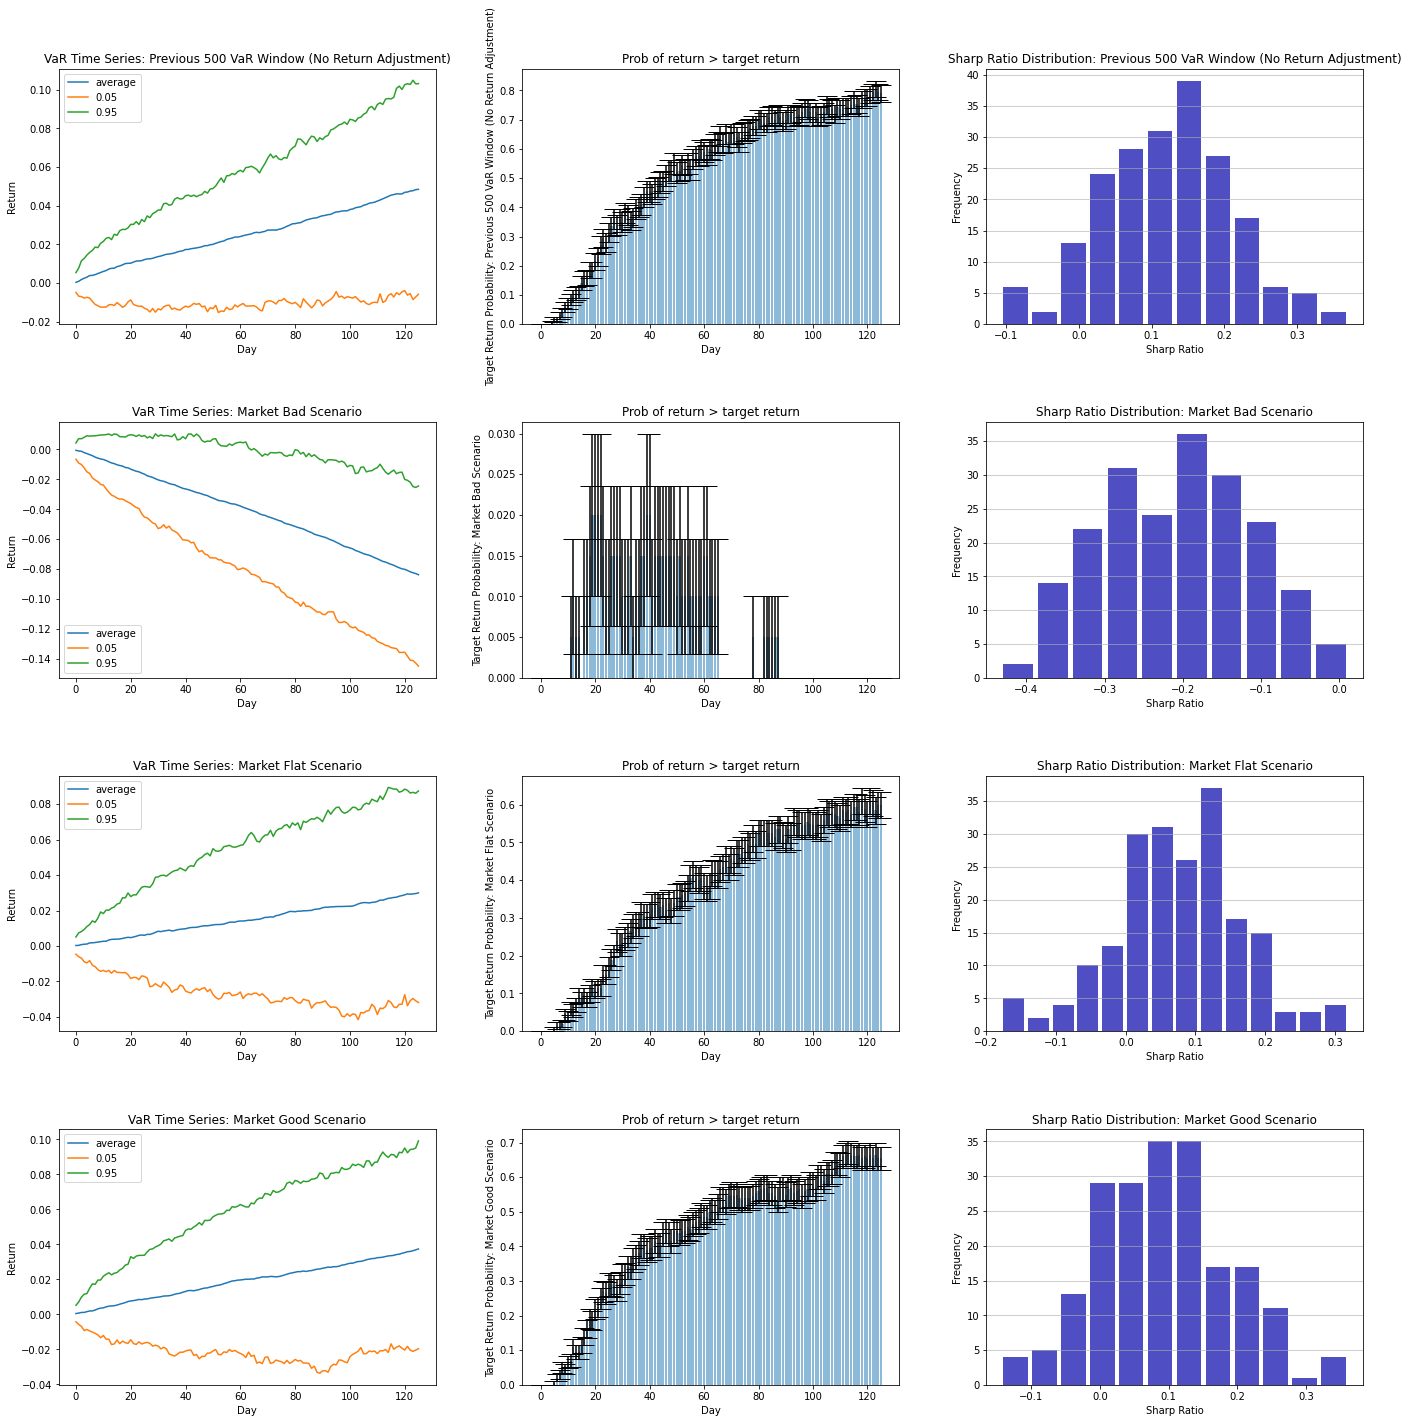

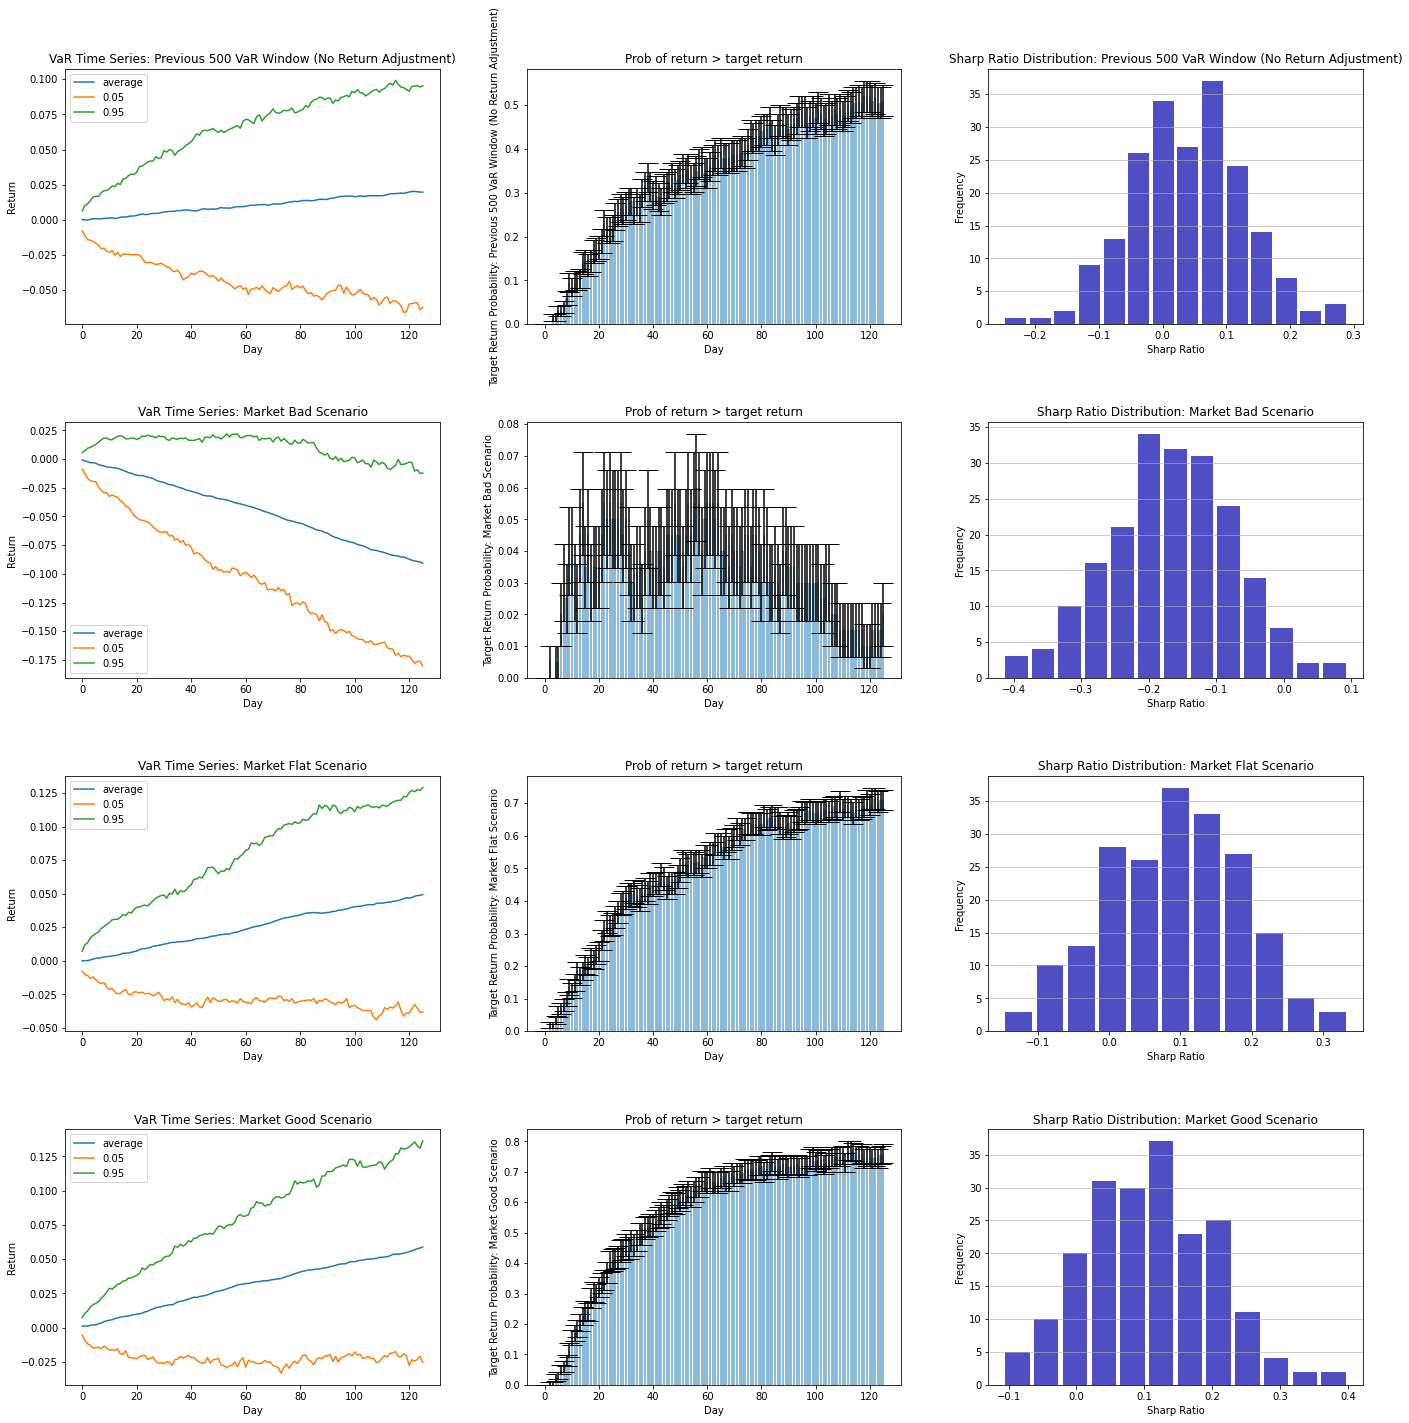

In [ ]:
forecast_days = 126
n_iterations = 200
tickers = 'SPY XLK IWO VXUS XIC.TO BND SHY VCSH IGOV XBB.TO XSH.TO VHT GLD VNQ'
df_data = yf.download(tickers=tickers, start="2010-01-01", end="2020-05-31",interval='1d')['Adj Close'].dropna()
portfolio_correctness_0 = pd.DataFrame([0]*len(df_data.columns), index=BL_output.index)
portfolio_correctness_0=portfolio_correctness_0.rename(columns={0: "difference"})

# 2008 stress testing: to create the 08 financial crisis senario
less_tickers = 'SPY XLK IWO XIC.TO BND SHY XBB.TO VHT GLD VNQ'
data_08 = yf.download(tickers=less_tickers, start="2008-06-01", end="2009-05-31",interval='1d')['Adj Close'].dropna()
ETF_08_return = data_08.pct_change().dropna()
ETF_08_return_mean = np.mean(ETF_08_return)

# 2012 stress testing: to create the 08 financial crisis senario
data_12 = df_data["2012-01-01":"2012-12-31"]
ETF_12_return = data_12.pct_change().dropna()
ETF_12_return_mean = np.mean(ETF_12_return)

# 2013 stress testing: to create the 08 financial crisis senario
data_13 = df_data["2013-01-01":"2013-12-31"]
ETF_13_return = data_13.pct_change().dropna()
ETF_13_return_mean = np.mean(ETF_13_return)

# stress testing: 
data_15 = yf.download(tickers=less_tickers, start="2010-01-01", end="2020-05-31",interval='1d')['Adj Close'].dropna()

# for loop of VaR and modify BL weight output 
invest_end_day = datetime.datetime.strptime("2015-04-01", '%Y-%m-%d').date()
num_of_rebalance = 2
target_return = 0.02


for i in range(num_of_rebalance): 

  invest_start_day = invest_end_day
  invest_end_day = invest_start_day + relativedelta(months=+6)
  # for last forcast period less than 6 months, use final day as last day

  if invest_end_day > final_day:
    invest_end_day = final_day
  
  end_day = (invest_start_day - BDay(n=1)).date()
  start_day = (end_day - BDay(n=500)).date()

  # select previous 500 days data
  df_data_rebalance = df_data[start_day:end_day]
  returns = df_data_rebalance.pct_change().dropna()
  
  # plot VaR
  fig=plt.figure(figsize=(20, 20))


  # Var caculation: based on past 2 yrs window shocks
  BL_weight = BL_output.iloc[:,i]
  VaR_0,SVaR_0, worst_ETF_0,sharpe_indices_0, target_prob_port_0, sharpe_indices_0, percentile_5th_0, percentile_95th_0, average_port_0 = VaRCalculation(returns, portfolio_correctness_0, BL_weight,forecast_days,n_iterations,target_return, 'Previous 500 VaR Window (No Return Adjustment)',fig, 1)
  
  if i==0:
    target_prob_port_df = pd.DataFrame() 
    percentile_5th_df = pd.DataFrame()
    percentile_95th_df = pd.DataFrame()
    average_port_df = pd.DataFrame()

    target_prob_port_df['target_prob_port'] = target_prob_port_0
    sharpe_indices_df= sharpe_indices_0
    percentile_5th_df['percentile_5th'] = percentile_5th_0
    percentile_95th_df['percentile_95th'] = percentile_95th_0
    average_port_df['average_port'] = average_port_0
  else: 
    target_prob_port_df['target_prob_port'] = (target_prob_port_df.target_prob_port + target_prob_port_0)/2
    sharpe_indices_df =  sharpe_indices_df.append(sharpe_indices_0)
    percentile_5th_df['percentile_5th'] = (percentile_5th_0 + percentile_5th_df.percentile_5th)/2
    percentile_95th_df['percentile_95th'] = (percentile_95th_0 + percentile_95th_df.percentile_95th)/2
    average_port_df['average_port'] = (average_port_0 + average_port_df.average_port)/2
  ###########################  
  # worst case stress testing (2008): 
  start_day_1yr = (end_day - BDay(n=250)).date()
  ETF_15_data_rebalance = data_15[start_day_1yr:end_day]
  ETF_15_return = ETF_15_data_rebalance.pct_change().dropna()
  ETF_15_return_mean = np.mean(ETF_15_return)

  # Get the known etf shock differences
  senario = pd.DataFrame()
  senario['08 return'] = ETF_08_return_mean
  senario['15 return'] = ETF_15_return_mean
  senario['difference'] = senario['08 return'] - senario['15 return']

  # based on the same asset type, estimate shocks difference for the eft that don't have 2008 data 
  senario.loc['VXUS'] = (senario.loc['SPY']+senario.loc['XLK']+senario.loc['XIC.TO'])/3
  senario.loc['VCSH'] = (senario.loc['BND']+senario.loc['SHY'])/2
  senario.loc['IGOV'] = (senario.loc['BND']+senario.loc['SHY']+senario.loc['XBB.TO'])/3
  senario.loc['XSH.TO'] = senario.loc['XBB.TO']
  # senario

  # Get portfolio correctness based on mean differences between last 1 year return and 2008 financial crisis return
  portfolio_correctness_08 = pd.DataFrame(senario.difference, index=BL_output.index)
  #print(portfolio_correctness_08)

  # Stress testing (Market bad): Var caculation: based on past 2 yrs window shocks
  VaR_st_08,SVaR_st_08, worst_ETF_st_08, sharpe_indices_st_08, target_prob_port_08, sharpe_indices_08, percentile_5th_08, percentile_95th_08, average_port_08 = VaRCalculation(returns, portfolio_correctness_08, BL_weight,forecast_days,n_iterations,target_return, "Market Bad Scenario",fig, 2)

  if i==0:
    target_prob_port_df['target_prob_port_worst'] = target_prob_port_08
    sharpe_indices_worst = sharpe_indices_08
    percentile_5th_df['percentile_5th_worst'] = percentile_5th_08
    percentile_95th_df['percentile_95th_worst'] = percentile_95th_08
    average_port_df['average_port_worst'] = average_port_08
  else: 
    target_prob_port_df['target_prob_port_worst'] = (target_prob_port_df.target_prob_port_worst + target_prob_port_08)/2
    sharpe_indices_worst = sharpe_indices_worst.append(sharpe_indices_08)
    percentile_5th_df['percentile_5th_worst'] = (percentile_5th_08 + percentile_5th_df.percentile_5th_worst)/2
    percentile_95th_df['percentile_95th_worst'] = (percentile_95th_08 + percentile_95th_df.percentile_95th_worst)/2
    average_port_df['average_port_worst'] = (average_port_08 + average_port_df.average_port_worst)/2
  ###########################  
  # normal case stress testing (2012): 
  # Get the known etf shock differences
  senario = pd.DataFrame()

  ETF_15_data_rebalance_all = df_data[start_day_1yr:end_day]
  ETF_15_return_all = ETF_15_data_rebalance_all.pct_change().dropna()
  ETF_15_return_mean_all = np.mean(ETF_15_return_all)

  senario['12 return'] = ETF_12_return_mean
  senario['15 return'] = ETF_15_return_mean_all
  senario['difference'] = senario['12 return'] - senario['15 return']


  # Get portfolio correctness based on mean differences between last 1 year return and 2012 financial crisis return
  portfolio_correctness_12 = pd.DataFrame(senario.difference, index=BL_output.index)
  #print(portfolio_correctness_12)

  # Stress testing: Var caculation: based on past 2 yrs window shocks
  VaR_st_12,SVaR_st_12, worst_ETF_st_12, sharpe_indices_st_12, target_prob_port_12, sharpe_indices_12, percentile_5th_12, percentile_95th_12, average_port_12 = VaRCalculation(returns, portfolio_correctness_12, BL_weight,forecast_days,n_iterations,target_return, "Market Flat Scenario",fig, 3)

  if i==0:
    target_prob_port_df['target_prob_port_flat'] = target_prob_port_12
    sharpe_indices_flat = sharpe_indices_12
    percentile_5th_df['percentile_5th_flat'] = percentile_5th_12
    percentile_95th_df['percentile_95th_flat'] = percentile_95th_12
    average_port_df['average_port_flat'] = average_port_12
  else: 
    target_prob_port_df['target_prob_port_flat'] = (target_prob_port_df.target_prob_port_flat + target_prob_port_12)/2
    sharpe_indices_flat = sharpe_indices_flat.append(sharpe_indices_12)
    percentile_5th_df['percentile_5th_flat'] = (percentile_5th_12 + percentile_5th_df.percentile_5th_flat)/2
    percentile_95th_df['percentile_95th_flat'] = (percentile_95th_12 + percentile_95th_df.percentile_95th_flat)/2
    average_port_df['average_port_flat'] = (average_port_12 + average_port_df.average_port_flat)/2
 
  ###########################  
  # case stress testing (2013) (market good): 
  # Get the known etf shock differences
  senario = pd.DataFrame()
  senario['13 return'] = ETF_13_return_mean
  senario['15 return'] = ETF_15_return_mean_all
  senario['difference'] = senario['13 return'] - senario['15 return']


  # Get portfolio correctness based on mean differences between last 1 year return and 2008 financial crisis return
  portfolio_correctness_13 = pd.DataFrame(senario.difference, index=BL_output.index)
  #print(portfolio_correctness_1yr)

  # Stress testing: Var caculation: based on past 2 yrs window shocks
  VaR_st_13,SVaR_st_13, worst_ETF_st_13, sharpe_indices_st_13, target_prob_port_13, sharpe_indices_13, percentile_5th_13, percentile_95th_13, average_port_13 = VaRCalculation(returns, portfolio_correctness_13, BL_weight,forecast_days,n_iterations,target_return, "Market Good Scenario",fig,4)


  if i==0:
    target_prob_port_df['target_prob_port_good'] = target_prob_port_13
    sharpe_indices_good = sharpe_indices_13
    percentile_5th_df['percentile_5th_good'] = percentile_5th_13
    percentile_95th_df['percentile_95th_good'] = percentile_95th_13
    average_port_df['average_port_good'] = average_port_13
  else: 
    target_prob_port_df['target_prob_port_good'] = (target_prob_port_df.target_prob_port_good + target_prob_port_13)/2
    sharpe_indices_good = sharpe_indices_good.append(sharpe_indices_13)
    percentile_5th_df['percentile_5th_good'] = (percentile_5th_13 + percentile_5th_df.percentile_5th_good)/2
    percentile_95th_df['percentile_95th_good'] = (percentile_95th_13 + percentile_95th_df.percentile_95th_good)/2
    average_port_df['average_port_good'] = (average_port_13 + average_port_df.average_port_good)/2

  fig.tight_layout()
  plt.savefig("Risk Model: Rebalance Period "+str(i))
  # modify over limit bl weight
  #if VaR < -0.8: # we need to change this VaR limit breach (for one day return in percentage)




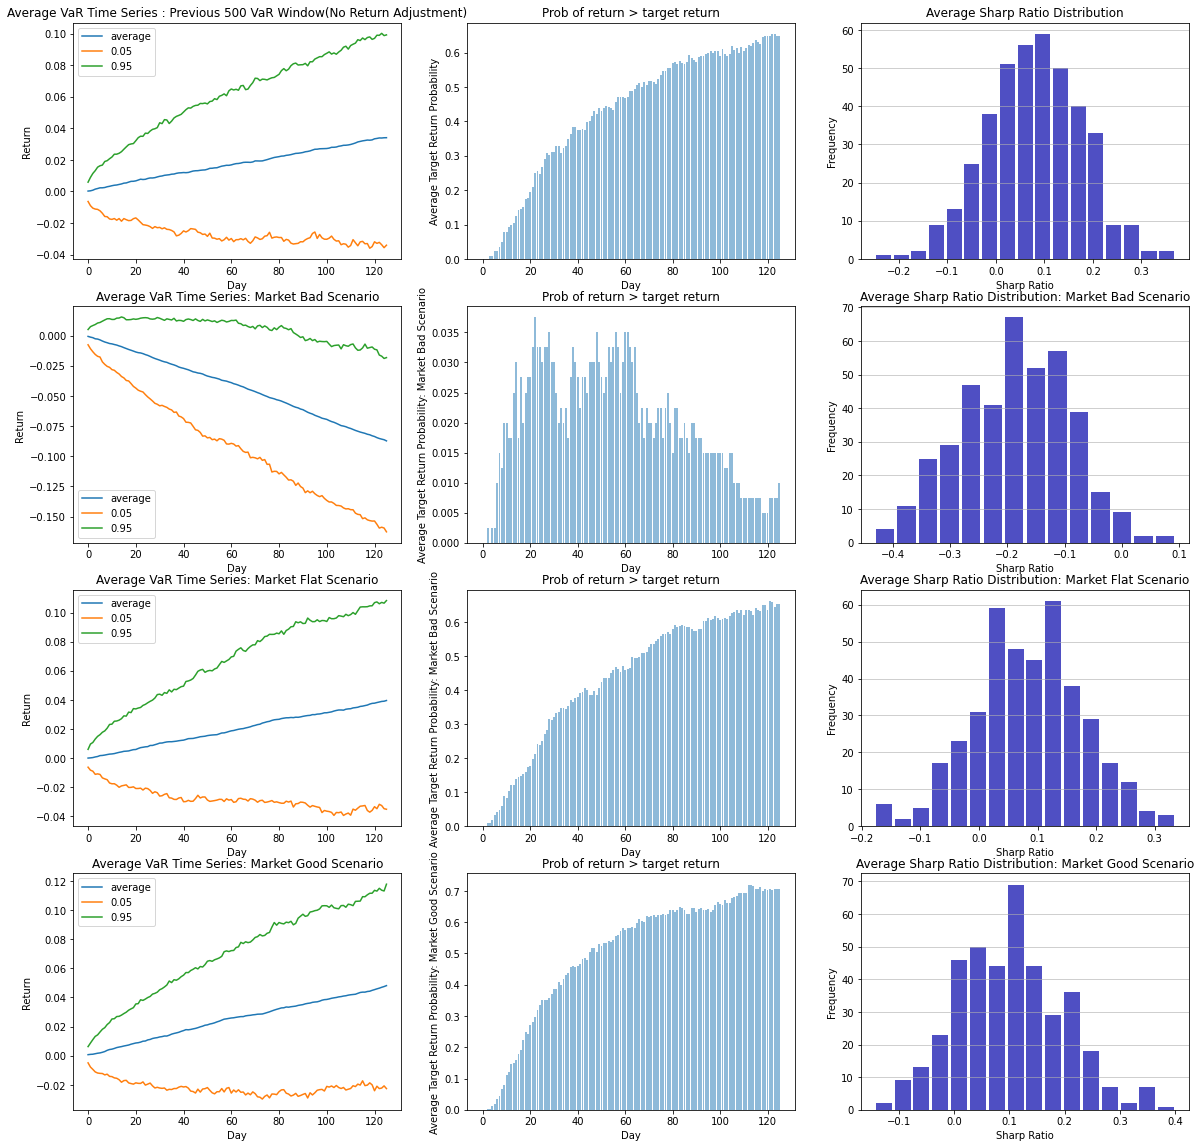

In [ ]:
# plot average VaR
fig=plt.figure(figsize=(20, 20))

# Previous 500 VaR Window(No Return Adjustment)
fig.add_subplot(4, 3, 1)
ax = plt.plot(average_port_df['average_port'],label="average")
plt.plot(percentile_5th_df['percentile_5th'],label="0.05")
plt.plot(percentile_95th_df['percentile_95th'],label="0.95")
plt.title("Average VaR Time Series : Previous 500 VaR Window(No Return Adjustment)")
plt.xlabel('Day')
plt.ylabel('Return')
plt.legend()


fig.add_subplot(4, 3, 2)
plt.bar(target_prob_port_df.index,target_prob_port_df.target_prob_port,
        # yerr=err_bars,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10)
plt.title("Prob of return > target return")
#ax.set_xticks(x_pos)
  # ax.set_xticklabels(labels)
plt.ylabel('Average Target Return Probability')
plt.xlabel('Day')

fig.add_subplot(4,3,3)

n, bins, patches = plt.hist(x=sharpe_indices_df, bins='auto', color='#0504aa',
                              alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Sharp Ratio')
plt.ylabel('Frequency')
plt.title('Average Sharp Ratio Distribution')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()


# average plot for 08 worst scenario
fig.add_subplot(4, 3, 4)
ax = plt.plot(average_port_df['average_port_worst'],label="average")
plt.plot(percentile_5th_df['percentile_5th_worst'],label="0.05")
plt.plot(percentile_95th_df['percentile_95th_worst'],label="0.95")
plt.title("Average VaR Time Series: Market Bad Scenario")
plt.xlabel('Day')
plt.ylabel('Return')
plt.legend()


fig.add_subplot(4, 3, 5)
plt.bar(target_prob_port_df.index,target_prob_port_df.target_prob_port_worst,
        # yerr=err_bars,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10)
plt.title("Prob of return > target return")
#ax.set_xticks(x_pos)
  # ax.set_xticklabels(labels)
plt.ylabel('Average Target Return Probability: Market Bad Scenario')
plt.xlabel('Day')

fig.add_subplot(4,3,6)

n, bins, patches = plt.hist(x=sharpe_indices_worst, bins='auto', color='#0504aa',
                              alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Sharp Ratio')
plt.ylabel('Frequency')
plt.title('Average Sharp Ratio Distribution: Market Bad Scenario')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()


# average plot for 12 flat scenario
fig.add_subplot(4, 3, 7)
ax = plt.plot(average_port_df['average_port_flat'],label="average")
plt.plot(percentile_5th_df['percentile_5th_flat'],label="0.05")
plt.plot(percentile_95th_df['percentile_95th_flat'],label="0.95")
plt.title("Average VaR Time Series: Market Flat Scenario")
plt.xlabel('Day')
plt.ylabel('Return')
plt.legend()


fig.add_subplot(4, 3, 8)
plt.bar(target_prob_port_df.index,target_prob_port_df.target_prob_port_flat,
        # yerr=err_bars,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10)
plt.title("Prob of return > target return")
#ax.set_xticks(x_pos)
  # ax.set_xticklabels(labels)
plt.ylabel('Average Target Return Probability: Market Bad Scenario')
plt.xlabel('Day')

fig.add_subplot(4,3,9)

n, bins, patches = plt.hist(x=sharpe_indices_flat, bins='auto', color='#0504aa',
                              alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Sharp Ratio')
plt.ylabel('Frequency')
plt.title('Average Sharp Ratio Distribution: Market Flat Scenario')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()

# average plot for 12 good scenario
fig.add_subplot(4, 3, 10)
ax = plt.plot(average_port_df['average_port_good'],label="average")
plt.plot(percentile_5th_df['percentile_5th_good'],label="0.05")
plt.plot(percentile_95th_df['percentile_95th_good'],label="0.95")
plt.title("Average VaR Time Series: Market Good Scenario")
plt.xlabel('Day')
plt.ylabel('Return')
plt.legend()


fig.add_subplot(4, 3, 11)
plt.bar(target_prob_port_df.index,target_prob_port_df.target_prob_port_good,
        # yerr=err_bars,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10)
plt.title("Prob of return > target return")
#ax.set_xticks(x_pos)
  # ax.set_xticklabels(labels)
plt.ylabel('Average Target Return Probability: Market Good Scenario')
plt.xlabel('Day')

fig.add_subplot(4,3,12)

n, bins, patches = plt.hist(x=sharpe_indices_good, bins='auto', color='#0504aa',
                              alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Sharp Ratio')
plt.ylabel('Frequency')
plt.title('Average Sharp Ratio Distribution: Market Good Scenario')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()

In [ ]:
print(target_prob_port_df)

     target_prob_port  ...  target_prob_port_good
0              0.0000  ...                 0.0000
1              0.0000  ...                 0.0000
2              0.0000  ...                 0.0025
3              0.0075  ...                 0.0025
4              0.0100  ...                 0.0125
..                ...  ...                    ...
121            0.6475  ...                 0.7050
122            0.6550  ...                 0.7025
123            0.6550  ...                 0.7050
124            0.6500  ...                 0.7050
125            0.6500  ...                 0.7075

[126 rows x 4 columns]


In [ ]:
print(target_prob_port_df)

     target_prob_port  ...  target_prob_port_good
0              0.0000  ...                 0.0000
1              0.0000  ...                 0.0000
2              0.0000  ...                 0.0025
3              0.0075  ...                 0.0025
4              0.0100  ...                 0.0125
..                ...  ...                    ...
121            0.6475  ...                 0.7050
122            0.6550  ...                 0.7025
123            0.6550  ...                 0.7050
124            0.6500  ...                 0.7050
125            0.6500  ...                 0.7075

[126 rows x 4 columns]


In [ ]:
print(sharpe_indices_df)

iteration_0      0.151839
iteration_1      0.014688
iteration_2      0.132996
iteration_3      0.088759
iteration_4      0.123215
                   ...   
iteration_195    0.067953
iteration_196    0.109136
iteration_197    0.068088
iteration_198    0.134615
iteration_199    0.100838
Length: 400, dtype: float64


In [ ]:
!pip install fpdf
from fpdf import FPDF




In [ ]:
# put all the graph in one pdf
pdf = FPDF()
num_of_rebalance = 2
for i in range(num_of_rebalance):
  pdf.add_page()
  pdf.set_xy(0, 0)
  pdf.set_font('arial', 'B', 13.0)
  # title
  image1 = 'Investment Plot: Rebalance Period '+str(i)+'.png'
  pdf.cell(ln=1, w=200,h=10, txt='Investment Plot: Rebalance Period '+str(i), align='C')
  # image
  pdf.image(image1, w=190, h=200)  
  # second page
  pdf.add_page()
  # title
  pdf.cell(ln=1, w=200, h=10, txt='Risk Model', align='C')
  # image
  image2 = 'Risk Model: Rebalance Period 0.png'
  pdf.image(image2, w=200, h=200)

pdf.output('report.pdf', 'F')

''